#Sentence Classification using BERT

In [1]:
import tensorflow as tf
# Verifying GPU availability (you have to turn it on in google colab)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
import torch

device = torch.device("cuda")

In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Loading csv file as df and removing irrelevant / empty (= multiple frames) frames
train_df = pd.read_csv('/content/drive/MyDrive/Studie/Thesis/train_set.csv')
validation_df = pd.read_csv('/content/drive/MyDrive/Studie/Thesis/val_set.csv')

In [6]:
print(train_df.shape)
print(validation_df.shape)

(7041, 13)
(1123, 13)


In [7]:
from sklearn import preprocessing

# Creating list of comments and corresponding labels
sentences_train = train_df.sentence.values
sentences_val = validation_df.sentence.values

# Getting labels           
labels_train = train_df.verif.values
labels_val = validation_df.verif.values

# Getting unique labels 
un_labels = set()
for label in labels_train:
  un_labels.add(label)
print(len(un_labels), un_labels)
# Rewriting labels from str to int so it can be 'understood' by the classifier 
le = preprocessing.LabelEncoder()
le.fit(sorted(un_labels))

train_labels = le.transform(labels_train)
validation_labels = le.transform(labels_val)

3 {'NonArg', 'Verif', 'UnVerif'}


In [8]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [9]:
def sent_to_id(sentences):
  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []

  # For every sentence...
  for sent in sentences:
      # `encode` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      encoded_sent = tokenizer.encode(
                          sent
                    )
      
      # Add the encoded sentence to the list.
      input_ids.append(encoded_sent)

  # Print sentence 0, now as a list of IDs.
  print('Original: ', sentences[0])
  print('Token IDs:', input_ids[0])
  return(input_ids)

In [10]:
train_inputs = sent_to_id(sentences_train)
validation_inputs = sent_to_id(sentences_val)

Original:  I have so many responses to this, but most of them stem from emotions, so I'm going to put them aside, and just go with two.
Token IDs: [101, 1045, 2031, 2061, 2116, 10960, 2000, 2023, 1010, 2021, 2087, 1997, 2068, 7872, 2013, 6699, 1010, 2061, 1045, 1005, 1049, 2183, 2000, 2404, 2068, 4998, 1010, 1998, 2074, 2175, 2007, 2048, 1012, 102]
Original:  You don't make any attempt to cite your claims.
Token IDs: [101, 2017, 2123, 1005, 1056, 2191, 2151, 3535, 2000, 21893, 2115, 4447, 1012, 102]


In [11]:
print('Max sentence length(train): ', max([len(sen) for sen in train_inputs]))
print('Max sentence length(validation): ', max([len(sen) for sen in validation_inputs]))

Max sentence length(train):  203
Max sentence length(validation):  137


In [12]:
# We will use some utility function from tensorflow(Tensorflow was my first crush)
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 305

#Padding the input to the max length that is 64
train_inputs = pad_sequences(train_inputs, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
validation_inputs = pad_sequences(validation_inputs, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")

In [13]:
def attentionmasks(input_ids):
  # Creating the attention masks
  attention_masks = []

  # For each sentence...
  for sent in input_ids:
      
      # Create the attention mask.
      #   - If a token ID is 0, then it's padding, set the mask to 0.
      #   - If a token ID is > 0, then it's a real token, set the mask to 1.
      att_mask = [int(token_id > 0) for token_id in sent]
      
      # Store the attention mask for this sentence.
      attention_masks.append(att_mask)
  return(attention_masks)

In [14]:
train_masks = attentionmasks(train_inputs)
validation_masks = attentionmasks(validation_inputs)

In [15]:
#Converting the input data to the tensor , which can be feeded to the model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [16]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#Creating the DataLoader which will help us to load data into the GPU/CPU
batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [17]:
#Loading the pre-trained BERT model from huggingface library

from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = 3,   
    output_attentions = False, 
    output_hidden_states = False, )

# Teeling the model to run on GPU
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [18]:
# AdamW is an optimizer which is a Adam Optimzier with weight-decay-fix
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 
                )


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [19]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
scheduler

Define a helper function for calculating accuracy.

In [20]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [21]:
#Creating the helper function to have a watch on elapsed time

import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [22]:
#Let's start the training process

import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    221.    Elapsed: 0:01:00.
  Batch    80  of    221.    Elapsed: 0:02:02.
  Batch   120  of    221.    Elapsed: 0:03:05.
  Batch   160  of    221.    Elapsed: 0:04:08.
  Batch   200  of    221.    Elapsed: 0:05:13.

  Average training loss: 0.64
  Training epoch took: 0:05:45

Running Validation...
  Accuracy: 0.78
  Validation took: 0:00:22

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    221.    Elapsed: 0:01:05.
  Batch    80  of    221.    Elapsed: 0:02:10.
  Batch   120  of    221.    Elapsed: 0:03:15.
  Batch   160  of    221.    Elapsed: 0:04:19.
  Batch   200  of    221.    Elapsed: 0:05:24.

  Average training loss: 0.45
  Training epoch took: 0:05:57

Running Validation...
  Accuracy: 0.78
  Validation took: 0:00:22

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    221.    Elapsed: 0:01:05.
  Batch    80  of    221.    Elapsed: 0:02:10.
  Batch   120  of    221.    Elapsed: 0:03:15.
  

25 min training time

In [23]:
print(loss_values) #Having a view of stored loss values in the list

[0.6361248735254167, 0.44543909460171316, 0.3150987568821303, 0.2250876522441795]


In [24]:
#Loading the test data and applying the same preprocessing techniques which we performed on the train data
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv('/content/drive/MyDrive/Studie/Thesis/test_set.csv')

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.sentence.values
labels = df.verif.values

labels = le.transform(labels)

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 1,962



In [25]:
#Evaluating our model on the test set

# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)



Predicting labels for 1,962 test sentences...


We will use Matthews Correlation Coefficient(MCC) to evaluate our model. 
MCC is used in many areas of Natural Language Processing. Also, it's a great metric to be used for imbalanced dataset

Link: https://towardsdatascience.com/the-best-classification-metric-youve-never-heard-of-the-matthews-correlation-coefficient-3bf50a2f3e9a


In [29]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


In [30]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('MCC: %.3f' % mcc)

MCC: 0.568


In [31]:
#for i in range(len(flat_true_labels)):
#  print(flat_true_labels[i], flat_predictions[i])
print(len(flat_predictions))
unique, counts = np.unique(flat_predictions, return_counts=True)
#unique, counts = np.unique(flat_true_labels, return_counts=True)
dict(zip(unique, counts))

# 0 = NonArg
# 1 = UnVerif
# 2 = Verif

1962


{0: 229, 1: 1214, 2: 519}

In [32]:
def show_plot(cm, labels):
        ax= plt.subplot()
        sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

        # labels, title and ticks
        ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels'); 
        ax.set_title('Confusion Matrix'); 
        ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
        plt.show()

Accuracy: 0.7502548419979612
micro: precision = 0.7502548419979612 	 recall = 0.7502548419979612 	 f1 = 0.7502548419979611
macro: precision = 0.7897824257416697 	 recall = 0.7273449690833248 	 f1 = 0.751629825638758
weighted: precision = 0.7543283912050037 	 recall = 0.7502548419979612 	 f1 = 0.7462450024299662
Per Class:
NonArg: precision = 0.9213973799126638 	 recall = 0.7455830388692579 	 f1 = 0.82421875
UnVerif: precision = 0.7331136738056013 	 recall = 0.8549471661863592 	 f1 = 0.7893569844789358
Verif: precision = 0.7148362235067437 	 recall = 0.5815047021943573 	 f1 = 0.641313742437338


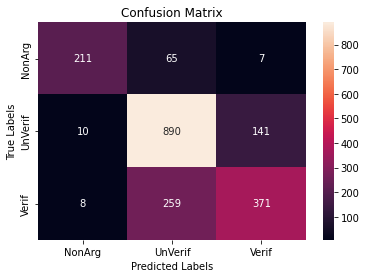

In [33]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

accuracy = accuracy_score(flat_true_labels, flat_predictions)
print("Accuracy: {}".format(accuracy))

macro = precision_recall_fscore_support(flat_true_labels, flat_predictions, average='macro')
micro = precision_recall_fscore_support(flat_true_labels, flat_predictions, average='micro')
weighted = precision_recall_fscore_support(flat_true_labels, flat_predictions, average='weighted')

print("micro: precision = {} \t recall = {} \t f1 = {}".format(micro[0], micro[1], micro[2]))
print("macro: precision = {} \t recall = {} \t f1 = {}".format(macro[0], macro[1], macro[2]))
print("weighted: precision = {} \t recall = {} \t f1 = {}".format(weighted[0], weighted[1], weighted[2]))

per_class = precision_recall_fscore_support(flat_true_labels, flat_predictions, average=None, labels=[0, 1, 2])
print("Per Class:")
print("NonArg: precision = {} \t recall = {} \t f1 = {}".format(per_class[0][0], per_class[1][0], per_class[2][0]))
print("UnVerif: precision = {} \t recall = {} \t f1 = {}".format(per_class[0][1], per_class[1][1], per_class[2][1]))
print("Verif: precision = {} \t recall = {} \t f1 = {}".format(per_class[0][2], per_class[1][2], per_class[2][2]))

cm = confusion_matrix(flat_true_labels, flat_predictions)
show_plot(cm, ['NonArg', 'UnVerif', 'Verif'])